In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from altair import Chart, X, Y, Scale
plt.style.use('bmh')
dirs = ['./output/2017-09-29/']
# os.listdir('output/2017-09-12')

To show:

* communication required vs rank
* num epochs vs rank

In [23]:
dfs = []
for dir in dirs:
    for filename in os.listdir(dir):
        print(filename)
        dfs += [pd.read_csv(dir + filename)]
df = pd.concat(dfs)
df['epoch_time'] = df['train_time'] / df['epoch']

1_2_34_True_10_4.csv
1_3_34_False_10_0.csv
1_2_34_True_10_1.csv
1_1_34_True_10_8.csv
1_2_34_True_10_2.csv
1_2_34_False_10_0.csv
1_1_34_False_10_0.csv
1_3_34_True_10_1.csv
1_0_34_False_10_0.csv
1_0_34_True_10_8.csv
1_0_34_True_10_4.csv
1_0_34_True_10_2.csv
1_0_34_True_10_1.csv
1_1_34_True_10_4.csv
1_1_34_True_10_2.csv
1_2_34_True_10_8.csv
1_1_34_True_10_1.csv


In [24]:
df.layers.unique()
df.columns

Index(['Unnamed: 0', 'approx_grad', 'augment', 'batch_size', 'dataset',
       'droprate', 'epoch', 'epochs', 'layers', 'lr', 'momentum', 'n_bytes',
       'name', 'nesterov', 'num_workers', 'print_freq', 'resume', 'seed',
       'start_epoch', 'svd_rank', 'tensorboard', 'test_acc', 'test_loss',
       'train_time', 'use_cuda', 'weight_decay', 'widen_factor', 'epoch_time'],
      dtype='object')

In [25]:
def epochs_required(df, acc=0.6, acc_key='test_acc'):
    df = df[df[acc_key] > acc]
    if len(df) == 0:
        print('retuning none')
        return None
    diff = np.abs(df[acc_key] - acc)
    return diff.argmin()

acc = 0.60
show = []
for rank in df.svd_rank.unique():
    if rank == 1:
        continue
    df_rank = df[df.svd_rank == rank]
    mean = df_rank.pivot_table(index='epoch', values=['test_acc'])
    epochs = epochs_required(mean, acc=acc) 
    n_bytes = df_rank.n_bytes.max()
    show += [{'rank': rank, 'n_bytes': n_bytes, 'epochs_required': epochs,
                  'acc': acc}]

In [26]:
show = pd.DataFrame(show)
show['rank'] = show['rank'].replace({0: None})
show = show.sort_values(by='rank')
show['kB'] = show.n_bytes / 1024
show['MB'] = show['kB'] / 1024
show.head()

,acc,epochs_required,n_bytes,rank,kB,MB
3,0.6,7,423360,2,413.437500,0.403748
0,0.6,6,837592,4,817.960938,0.798790
2,0.6,5,1666056,8,1627.007812,1.588875
1,0.6,4,1866856,None,1823.101562,1.780373


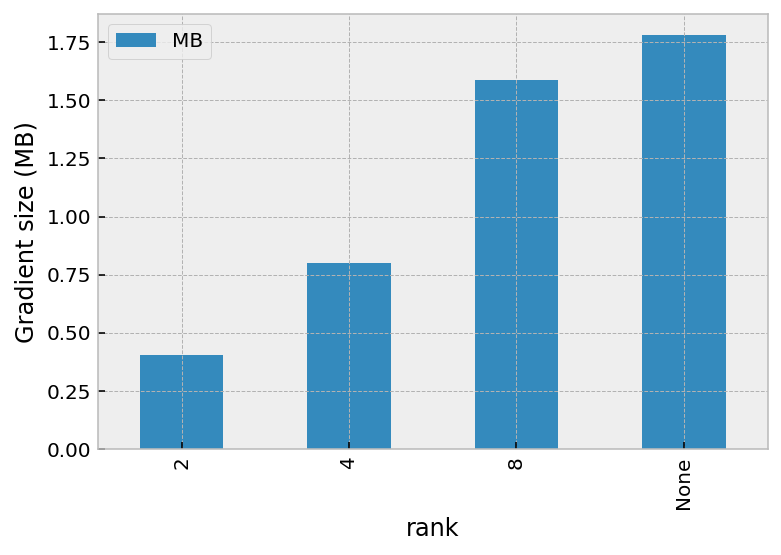

In [27]:
show.plot.bar(x='rank', y='MB', style='o')
plt.ylabel('Gradient size (MB)')

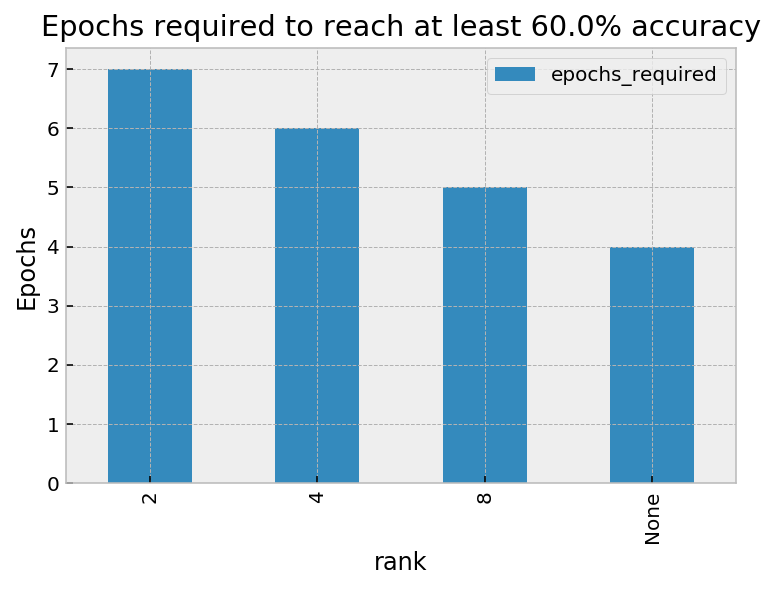

In [28]:
show.plot.bar(x='rank', y='epochs_required')
plt.ylabel('Epochs')
plt.title(f'Epochs required to reach at least {acc*100}% accuracy')

In [30]:
# communication is "time"
# accuracy 
show['total_bytes'] = show['epochs_required'] * show['n_bytes']
# show['total_bytes']

In [31]:
bytes_no_approx = show.iloc[-1]['total_bytes']
show['speedup'] = bytes_no_approx / show['total_bytes'] 
show.head()

,acc,epochs_required,n_bytes,rank,kB,MB,total_bytes,speedup
3,0.6,7,423360,2,413.437500,0.403748,2963520,2.519782
0,0.6,6,837592,4,817.960938,0.798790,5025552,1.485891
2,0.6,5,1666056,8,1627.007812,1.588875,8330280,0.896419
1,0.6,4,1866856,None,1823.101562,1.780373,7467424,1.000000


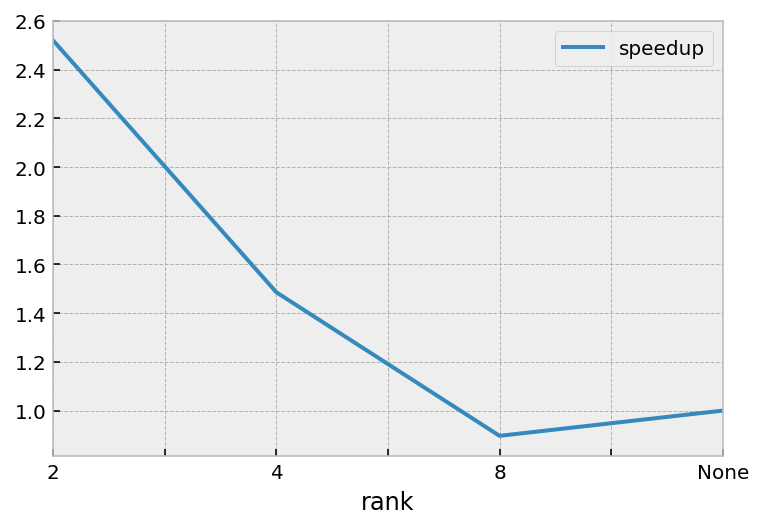

In [32]:
show.plot(x='rank', y='speedup')